# Introduction

The followig aims to train a movie recommendation system which will accurately predict a person's rating of an unseen  movie based on their historic choices.

## Importing packages

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNWithZScore
from surprise import BaselineOnly
   
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from surprise import accuracy
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Reading in data

In [2]:
df_sample_submission = pd.read_csv('sample_submission.csv')
df_movies = pd.read_csv('movies.csv')
df_imdb = pd.read_csv('imdb_data.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')

In [3]:
df_test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [4]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [5]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [6]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [7]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [9]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [10]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [11]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
df_sample_submission.head(10)

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0
5,1_8405,1.0
6,1_8786,1.0
7,2_150,1.0
8,2_356,1.0
9,2_497,1.0


## EDA
Discovery phase and data understanding

**Most common Genres**

In [13]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


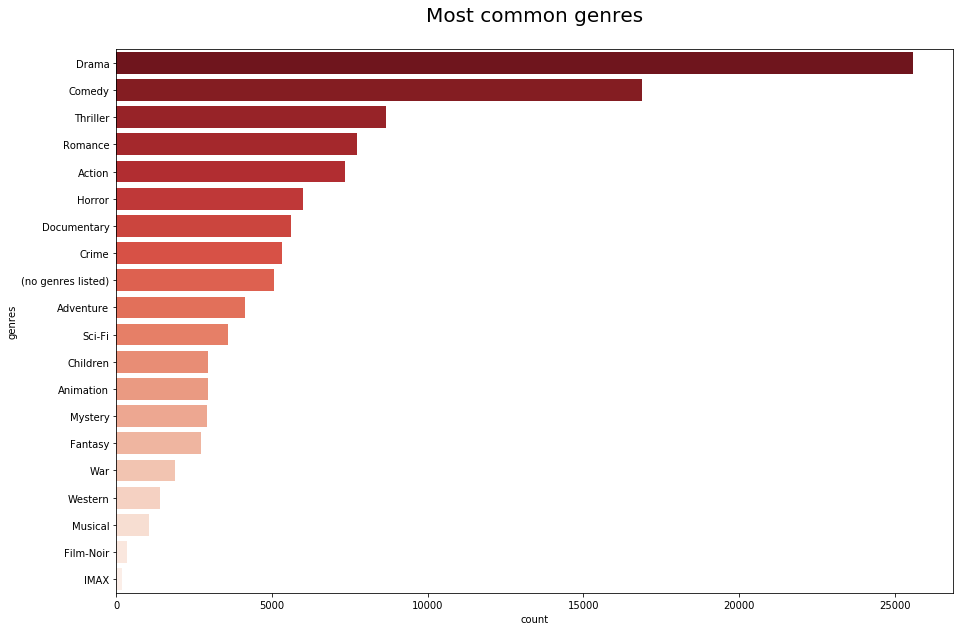

In [14]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

## Data Prepartion

Deleting unnecessary columns

In [15]:
df_train = df_train.drop('timestamp',axis = 1)
df_tags = df_tags.drop('timestamp',axis = 1)

Merging the dataframes

In [16]:
data = pd.merge(df_train , df_movies , how='outer', on='movieId')
test = pd.merge(df_test , df_movies , how='outer', on='movieId')
test.head()

,userId,movieId,title,genres
0,1.0,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
1,13.0,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
2,54.0,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
3,57.0,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
4,120.0,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi


Converting Genres into different columns 
Here we just create columns and put there initial value as 0

In [17]:
x = data.genres
a = list()
for i in x:
    abc = i
    a.append(abc.split('|'))
a = pd.DataFrame(a)   
b = a[0].unique()
for i in b:
    data[i] = 0
data.head(2)

,userId,movieId,rating,title,genres,Comedy,Action,Adventure,Drama,Animation,...,Mystery,Sci-Fi,Documentary,Musical,Western,Romance,Film-Noir,(no genres listed),War,IMAX
0,5163.0,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,87388.0,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
data.shape

(10014248, 25)

In [19]:
x = test.genres
a = list()
for i in x:
    abc = i
    a.append(abc.split('|'))
a = pd.DataFrame(a)   
b = a[0].unique()
for i in b:
    test[i] = 0

we assign 1 to all the columns which are present in the Genres


In [20]:
for i in b:
    data.loc[data['genres'].str.contains(i), i] = 1
data.head(2)

,userId,movieId,rating,title,genres,Comedy,Action,Adventure,Drama,Animation,...,Mystery,Sci-Fi,Documentary,Musical,Western,Romance,Film-Noir,(no genres listed),War,IMAX
0,5163.0,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,87388.0,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
for i in b:
    test.loc[test['genres'].str.contains(i), i] = 1

Now there is no use of genre 
Since we have movie id so there is no need for movie names as well

In [22]:
data = data.drop(['genres','title'],axis =1)
test = test.drop(['genres','title'],axis =1)
data.head()

,userId,movieId,rating,Comedy,Action,Adventure,Drama,Animation,Horror,Fantasy,...,Mystery,Sci-Fi,Documentary,Musical,Western,Romance,Film-Noir,(no genres listed),War,IMAX
0,5163.0,57669,4.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,87388.0,57669,3.5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,137050.0,57669,4.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,120490.0,57669,4.5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50616.0,57669,4.5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


check if merging did not create nulls

In [23]:
data.isnull().sum()

userId                14210
movieId                   0
rating                14210
Comedy                    0
Action                    0
Adventure                 0
Drama                     0
Animation                 0
Horror                    0
Fantasy                   0
Thriller                  0
Children                  0
Crime                     0
Mystery                   0
Sci-Fi                    0
Documentary               0
Musical                   0
Western                   0
Romance                   0
Film-Noir                 0
(no genres listed)        0
War                       0
IMAX                      0
dtype: int64

In [24]:
test.isnull().sum()

userId                22780
movieId                   0
Adventure                 0
Drama                     0
Comedy                    0
Action                    0
Children                  0
Crime                     0
Horror                    0
Documentary               0
Animation                 0
Sci-Fi                    0
Fantasy                   0
Mystery                   0
Thriller                  0
Western                   0
Romance                   0
Film-Noir                 0
Musical                   0
(no genres listed)        0
War                       0
IMAX                      0
dtype: int64

Since we see it created some, we drop them from both the training and testing data sets

In [25]:
#WE simply drop the null values coz the are not treatable
data.dropna(inplace= True )
test.dropna(inplace= True )

In [26]:
data.isnull().sum()

userId                0
movieId               0
rating                0
Comedy                0
Action                0
Adventure             0
Drama                 0
Animation             0
Horror                0
Fantasy               0
Thriller              0
Children              0
Crime                 0
Mystery               0
Sci-Fi                0
Documentary           0
Musical               0
Western               0
Romance               0
Film-Noir             0
(no genres listed)    0
War                   0
IMAX                  0
dtype: int64

In [27]:
data.shape

(10000038, 23)

## Modelling phase

To reduce the dimensionality of the data set, and avoid running into “memory error”, we will filter out rarely rated movies and rarely rating users.

In [28]:
min_movie_ratings = 50
filter_movies = data['movieId'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_ratings = 50
filter_users = data['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = data[(data['movieId'].isin(filter_movies)) & (data['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(data.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(10000038, 23)
The new data frame shape:	(7382932, 23)


In [29]:
df_new.head()

,userId,movieId,rating,Comedy,Action,Adventure,Drama,Animation,Horror,Fantasy,...,Mystery,Sci-Fi,Documentary,Musical,Western,Romance,Film-Noir,(no genres listed),War,IMAX
1,87388.0,57669,3.5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,137050.0,57669,4.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50616.0,57669,4.5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,99887.0,57669,0.5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,847.0,57669,3.5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_new[['userId', 'movieId', 'rating']], reader)

In [31]:
trainset, testset = train_test_split(data, test_size=0.01)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures="rmse", cv=3)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

In [ ]:
ratings_predictions=[algo.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]

In [ ]:
df_pred=pd.DataFrame(ratings_predictions)
df_pred

In [ ]:
df_pred=df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
df_pred.drop(['r_ui','details'],axis=1,inplace=True)

In [ ]:
df_pred.head()

In [ ]:
my_submission = pd.DataFrame({'id': df_sample_submission.Id, 'rating': df_pred.rating})
my_submission.head()

In [ ]:
my_submission.to_csv("BaselineOnly.csv", index=False)

# Generate your outputs here

Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.


### Make Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

Example below of how the output would look once published